In [1]:
import pandas as pd

In [2]:
# Update the path below to match your actual file location
df = pd.read_csv(r'../Dataset/nasa_power_prepared_data.csv')  # Use relative path or provide the correct absolute path


In [3]:
df.head(3)

,date,evland,evptrns,gwetprof,gwetroot,gwettop,hdd0,hdd10,hdd18_3,pbltop,...,day,week,weekday,season_num,et_total,t2m_forecast_7d,rain_forecast_7d,et_forecast_7d,soil_moisture_forecast_7d,wind_forecast_7d
0,1981-01-01,1.88,0.34,0.61,0.61,0.62,0.0,0.0,0.0,93.03,...,1,1,3,0,2.22,27.44,0.06,1.57,0.56,1.95
1,1981-01-02,1.77,0.28,0.61,0.60,0.62,0.0,0.0,0.0,91.99,...,2,1,4,0,2.05,26.87,0.00,1.47,0.55,2.52
2,1981-01-03,1.72,0.24,0.60,0.60,0.62,0.0,0.0,0.0,91.67,...,3,1,5,0,1.96,26.14,0.00,1.40,0.54,3.58


In [4]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================
# 1. Load Data
# ============================
df = pd.read_csv("../Dataset/nasa_power_prepared_data.csv", parse_dates=["date"])
df = df.sort_values("date")


In [5]:
TARGET_COL = "t2m"
COLS_TO_DROP_PRE_TRAIN = ["date", "season_num", "year", "month", "day", "week", "weekday"]

features = [col for col in df.columns if col not in COLS_TO_DROP_PRE_TRAIN + [TARGET_COL]]

In [6]:
SPLIT_DATE = "2015-01-01"
train = df[df["date"] < SPLIT_DATE]
test = df[df["date"] >= SPLIT_DATE]

X_train, y_train = train[features], train[TARGET_COL]
X_test, y_test = test[features], test[TARGET_COL]


In [7]:
XGB_PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "max_depth": 6,
    "random_state": 42,
    "n_jobs": -1
}

base_model = XGBRegressor(**XGB_PARAMS)
base_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
y_pred_base = base_model.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"[Base Model] RMSE: {rmse_base:.3f}, R²: {r2_base:.3f}")


[Base Model] RMSE: 0.083, R²: 0.998


In [9]:
importance = base_model.feature_importances_
feat_imp = pd.DataFrame({"feature": features, "importance": importance})
feat_imp = feat_imp.sort_values("importance", ascending=False)


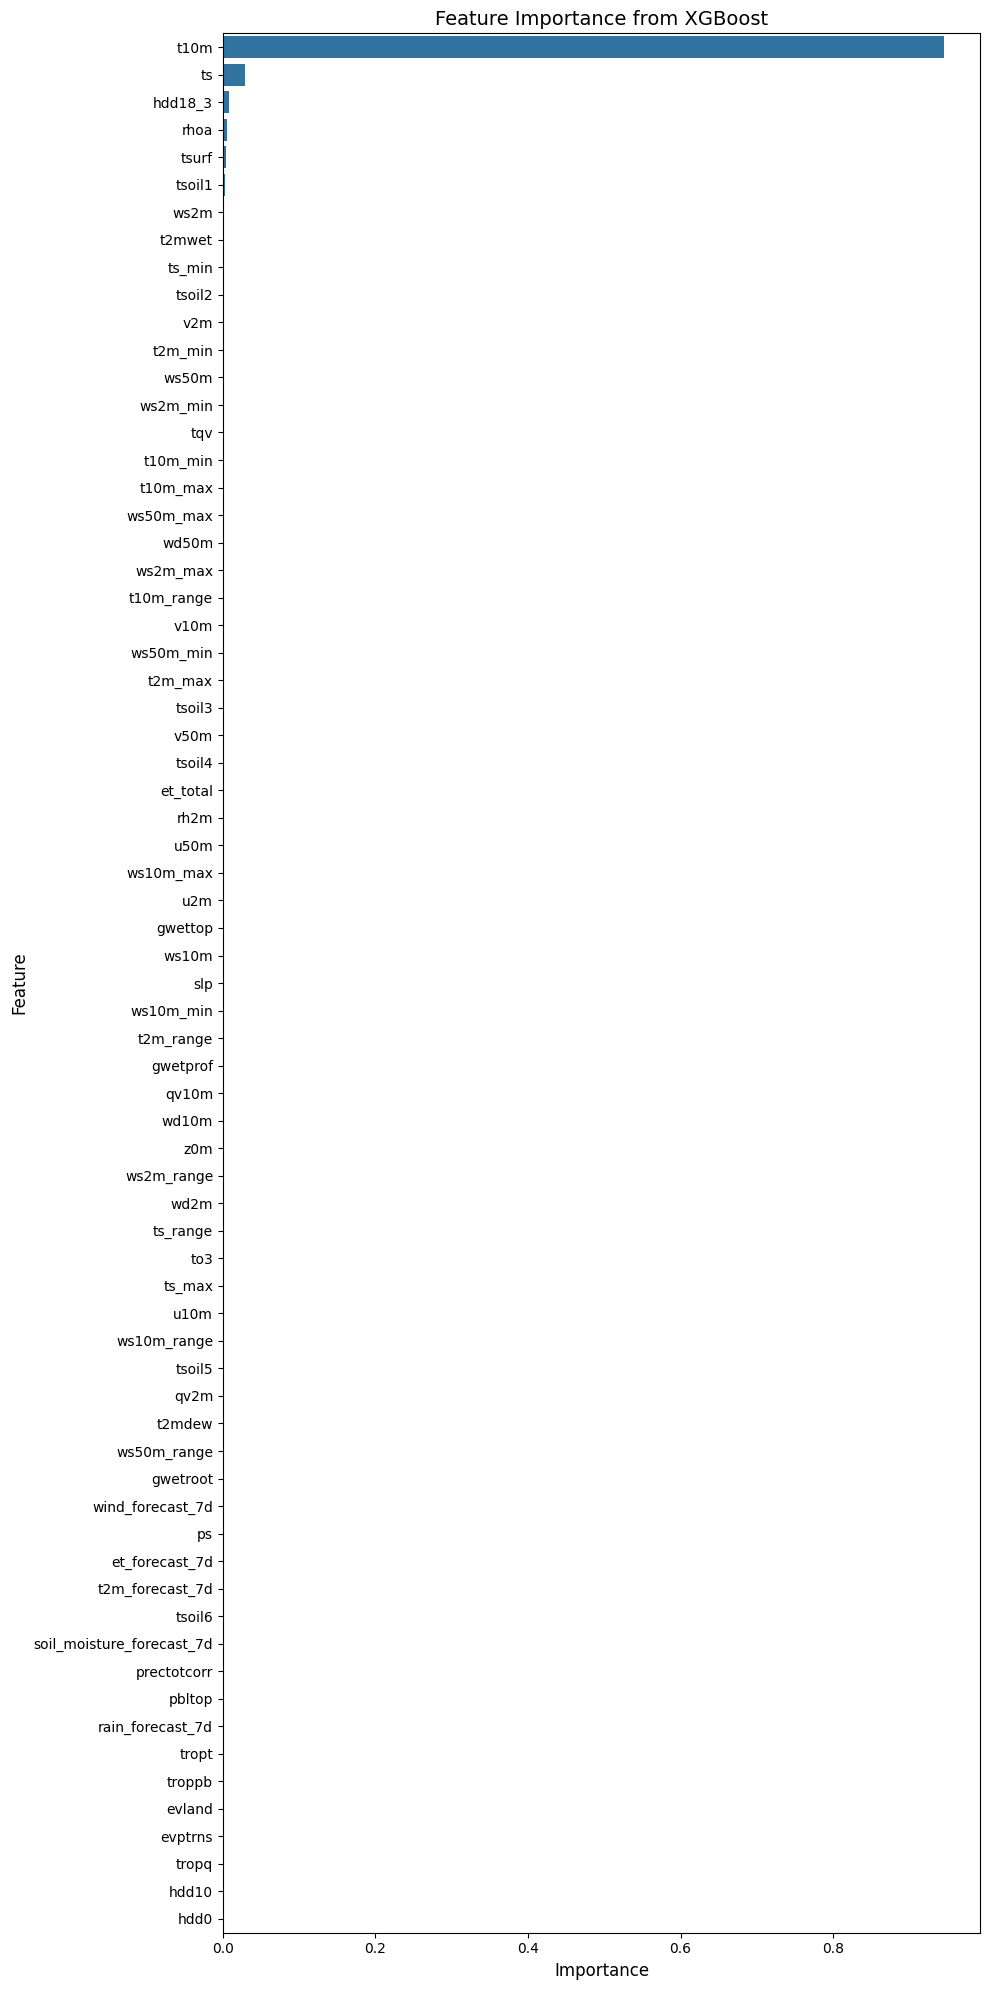

In [10]:
plt.figure(figsize=(10, 20))  # เพิ่มความสูง
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Feature Importance from XGBoost", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.yticks(fontsize=10)  # ปรับขนาดตัวอักษร
plt.tight_layout()       # จัด layout ให้ไม่ซ้อนกัน
plt.show()


In [11]:
TOP_K = 10
selected_features = feat_imp.head(TOP_K)["feature"].tolist()

X_train_sel, X_test_sel = X_train[selected_features], X_test[selected_features]

model_sel = XGBRegressor(**XGB_PARAMS)
model_sel.fit(X_train_sel, y_train)

y_pred_sel = model_sel.predict(X_test_sel)
rmse_sel = np.sqrt(mean_squared_error(y_test, y_pred_sel))
r2_sel = r2_score(y_test, y_pred_sel)

print(f"[Selected Features Model] RMSE: {rmse_sel:.3f}, R²: {r2_sel:.3f}")


[Selected Features Model] RMSE: 0.075, R²: 0.998


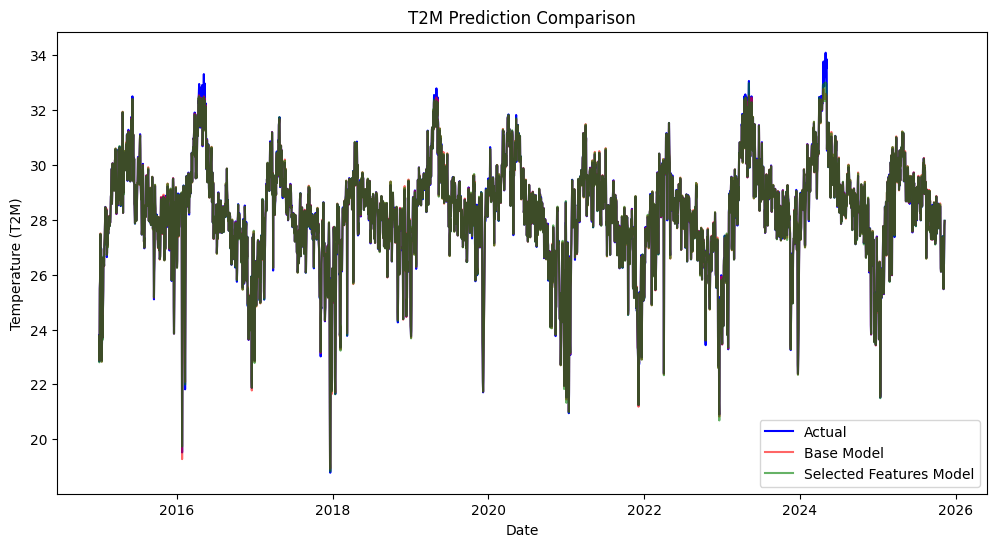

In [12]:
plt.figure(figsize=(12,6))
plt.plot(test["date"], y_test, label="Actual", color="blue")
plt.plot(test["date"], y_pred_base, label="Base Model", color="red", alpha=0.6)
plt.plot(test["date"], y_pred_sel, label="Selected Features Model", color="green", alpha=0.6)
plt.title("T2M Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("Temperature (T2M)")
plt.legend()
plt.show()
